In [24]:
import pandas as pd
import numpy as np
import re
import sklearn

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("train.csv",header=0,dtype={"Age":np.float64})
test = pd.read_csv("test.csv",header=0,dtype={"Age":np.float64})
full_data = [train,test]

In [3]:
# 参看数据信息
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
# 特征工程

In [5]:
# 类别
train[["Pclass","Survived"]].groupby(["Pclass"],as_index = False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [6]:
# 性别
train[["Sex","Survived"]].groupby("Sex",as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [7]:
# 家庭成员
for dataset in full_data:
    dataset["FamilySize"] = dataset["SibSp"] + dataset["Parch"]+1
train[["FamilySize","Survived"]].groupby("FamilySize",as_index=False).mean()

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [8]:
# 是否独自一人影响
for dataset in full_data:
    dataset["IsAlone"] = 0
    dataset.loc[dataset["FamilySize"]==1,"IsAlone"] = 1
train[["IsAlone","Survived"]].groupby(["IsAlone"],as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [9]:
# 登船
for dataset in full_data:
    dataset["Embarked"] = dataset["Embarked"].fillna("S")
train[["Embarked","Survived"]].groupby("Embarked",as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [10]:
# 票件
for dataset in full_data:
    dataset["Fare"] = dataset["Fare"].fillna(train["Fare"].median())
train["CategoricalFare"] = pd.qcut(train["Fare"],4)
train[["CategoricalFare","Survived"]].groupby("CategoricalFare",as_index=False).mean()

,CategoricalFare,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [11]:
# 年龄
for dataset in full_data:
    age_avg = dataset["Age"].mean()
    age_std = dataset["Age"].std()
    age_null_count = dataset["Age"].isnull().sum()
    age_null_random_list = np.random.randint(age_avg-age_std,age_avg+age_std,size=age_null_count)
    dataset["Age"][np.isnan(dataset["Age"])] = age_null_random_list
    dataset["Age"] = dataset["Age"].astype(int)
train["CategoricalAge"] = pd.cut(train["Age"],5)
train[["CategoricalAge","Survived"]].groupby(["CategoricalAge"],as_index=False).mean()

c:\users\caiwei\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,CategoricalAge,Survived
0,"(-0.08, 16.0]",0.527273
1,"(16.0, 32.0]",0.363029
2,"(32.0, 48.0]",0.357143
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [12]:
# 名字
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
pd.crosstab(train["Title"],train["Sex"])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [13]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
    'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace(['Mlle'], 'Miss')
    dataset['Title'] = dataset['Title'].replace(['Ms'], 'Miss')
    dataset['Title'] = dataset['Title'].replace(['Mme'], 'Mrs')
train[["Title","Survived"]].groupby(["Title"],as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [14]:
# 数据清洗
for dataset in full_data:
    # 性别
    dataset["Sex"] = dataset["Sex"].map({"female":0,"male":1}).astype(int)
    # 题目
    dataset["Title"] = dataset["Title"].map({"Mr":1,"Miss":2,"Mrs":3,"Master":4,"Rare":5})
    dataset["Title"] = dataset["Title"].fillna(0)
    # 上岸
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    # 票价
    dataset.loc[dataset["Fare"]<=7.91,"Fare"] = 0
    dataset.loc[(dataset["Fare"]>7.91)&(dataset["Fare"]<=14.454),"Fare"] = 1
    dataset.loc[(dataset["Fare"]>14.454)&(dataset["Fare"]<=31),"Fare"] = 2
    dataset.loc[(dataset["Fare"]>31,"Fare")] = 3
    dataset["Fare"] = dataset["Fare"].astype(int)
    # 年龄
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4    

In [15]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0,NaN,0,2,0,"(-0.001, 7.91]","(16.0, 32.0]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,3,C85,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",3
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,1,NaN,0,1,1,"(7.91, 14.454]","(16.0, 32.0]",2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2,1,0,113803,3,C123,0,2,0,"(31.0, 512.329]","(32.0, 48.0]",3
4,5,0,3,"Allen, Mr. William Henry",1,2,0,0,373450,1,NaN,0,1,1,"(7.91, 14.454]","(32.0, 48.0]",1


In [16]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Title
0,892,3,"Kelly, Mr. James",1,2,0,0,330911,0,NaN,2,1,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,2,1,0,363272,0,NaN,0,2,0,3
2,894,2,"Myles, Mr. Thomas Francis",1,3,0,0,240276,1,NaN,2,1,1,1
3,895,3,"Wirz, Mr. Albert",1,1,0,0,315154,1,NaN,0,1,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,1,1,1,3101298,1,NaN,0,3,0,3


In [17]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp',\
                 'Parch', 'FamilySize']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)

test  = test.drop(drop_elements, axis = 1)

In [18]:
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone,Title
0,0,3,1,1,0,0,0,1
1,1,1,0,2,3,1,0,3
2,1,3,0,1,1,0,1,2
3,1,1,0,2,3,0,0,3
4,0,3,1,2,1,0,1,1


In [19]:
test.head()

,Pclass,Sex,Age,Fare,Embarked,IsAlone,Title
0,3,1,2,0,2,1,1
1,3,0,2,0,0,0,3
2,2,1,3,1,2,1,1
3,3,1,1,1,0,1,1
4,3,0,1,1,0,0,3


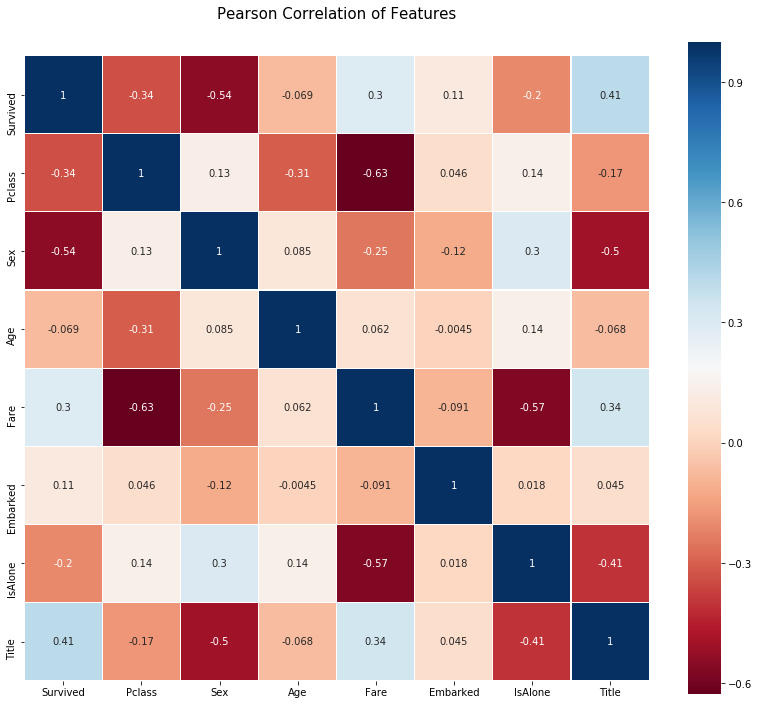

In [20]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [26]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

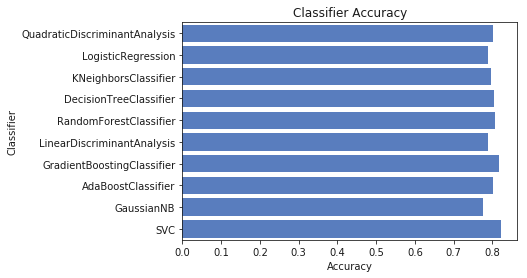

In [61]:
log_cols = ["Classifier", "Accuracy"]
log  = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = train.iloc[:, 1:]
y = train.iloc[:, 0]
# print(type(X))
# print(y)
acc_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

In [63]:
candidate_classifier = SVC()
candidate_classifier.fit(train.iloc[:, 1:], train.iloc[:, 0])
result = candidate_classifier.predict(test)
result

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0,

In [46]:
train.head()["Survived"]

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64